## Ziel des Notebooks
Das Ziel ist es, Betrugsfälle (FRAUD) in Kassendaten zu erkennen und die dabei entstehenden Schäden zu schätzen. Dazu wird ein Klassifikationsmodell (zur Wahrscheinlichkeitsabschätzung von FRAUD) mit einem Regressionsmodell (zur Schadenshöhe) kombiniert, um basierend auf den erwarteten Kosten und Nutzen optimale Kontrollstrategien zu ermitteln.


## Datenimport und Vorbereitung
Datenquellen:
transformed_label.parquet: enthält Features und das Label ("FRAUD" oder "NORMAL") und
transformed_damage.parquet: enthält Transaktionen mit zugehörigem Schaden


## Preprocessing-Schritte:
Auswahl nur der relevanten Features auf Basis Chi²-Test etc.( u. a. payment_medium, hour, has_snacks, has_feedback, etc.

Zusammenführung mit der Schadenstabelle über transaction_id.
Fehlende Schäden (NORMAL-Fälle) werden mit 0 ersetzt.
Die Vorabanalyse ergab drei verschieden Kategorien von Transaktionen:

## Aufteilung der gelabelten Datensätze nach Kategorien

| Kategorie   | Anzahl Datensätze | Anzahl NORMAL | Anzahl FRAUD | Prozent FRAUD | damage in €  | damage mean  | damage median |
|-------------|-------------------|---------------|--------------|----------------|--------------|--------------|----------------|
| unscanned   |     377           | 0             | 377          | 100.0%         | 5.088 €      | 13,5 €       | 9,7 €          |
| Rabatte     |  11.083           | 8.401         | 2.682        | 31.9%          | 18.289 €     | 6,8 €        | 5,2 €          |
| übrige      | 136.564           | 136.968       | 1.596        | 1.2%           | 11.786 €     | 7,4 €        | 4,8 €          |
| **gesamt**  | **148.024**       | **143.369**   | **4.655**    | **3.1%**       | **35.163 €** | **7,6 €**     | **5,2 €**       |


## Kategorie "unscanned"
Es handelt sich um Transaktionen, bei denen von der Kamera fehlende Positionen erkannt wurden und automatisch in die Transaktion als FRAUD aufgenommen wurden.(Merkmal: sales_price = 0 und was_voided = True) 
Diese Transaktionen sollten außerhalb des Modells behandelt werden (zum Beispiel durch vollständige manuelle Kontrolle),da hier in allen Fällen ein FRAUD vorliegt.

## Kategorie "Rabatte"
Es handelt sich um Transaktionen, bei denen der rechnerissche sales_price (Menge * Preis laut Preisdatei/Menge) nicht mit dem in der Transaktion erfassten sales_price übereinstimmt. Der Grund hierfür liegt in der Verwendung eines Buttons für Rabatte ind Höhe von 30% für Ware kurz vor Ablauf des MHD. Offensichtlich kann der Kunde durch Benutzen einer entsprechenden Taste diesen Rabatt sebständig in Anspruch nehmen. **Wie die folgende Auswertung zeigt, sind jedoch in den meisten Kategorien keine Rabatte vorgesehen. Die Wertkauf GmbH sollte die Rabattfunktion entsprechend für diese Kategorien deaktivieren. Der dadurch verhinderbare Schaden beträgt 7.335,82 €**

Achtung! Die folgende Auswertung bezieht sich auf **Positionen**

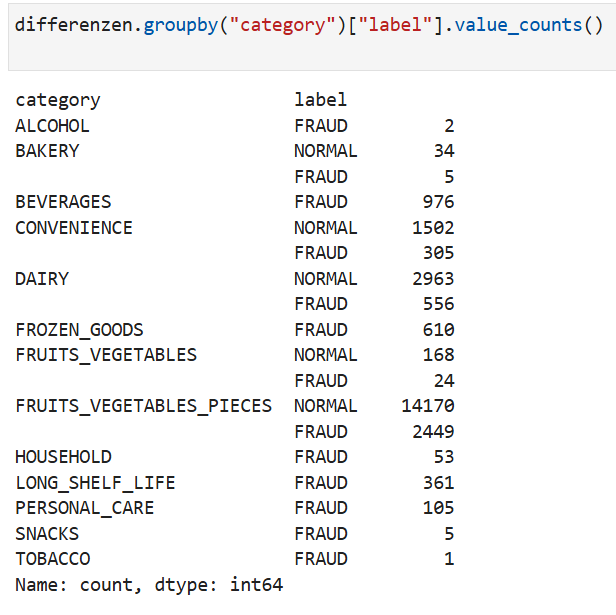

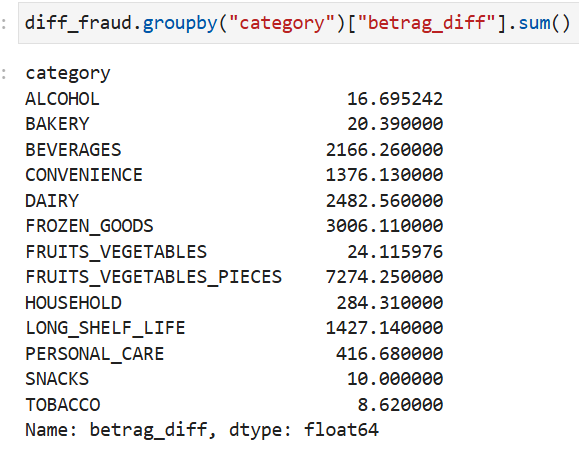

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
tr_label = pd.read_parquet("transformed_label.parquet", engine="fastparquet")
tr_damage = pd.read_parquet("transformed_damage.parquet", engine="fastparquet")

In [31]:
#tr_label.info()

In [4]:
tr_label = tr_label[['label','transaction_id', 'payment_medium',
       'has_feedback', 'feedback_categorical', 'hour','n_lines',"transaction_duration_seconds",
       'has_voided',  'has_unscanned',"calculated_price_difference",'has_camera_detected_wrong_product',
       'has_camera_detected_wrong_product_high_certainty','has_positive_price_difference', 'has_snacks', 
       'has_bakery', 'has_frozen_goods', 'has_personal_care', 'has_fruits_vegetables',
       'has_household','has_dairy','has_beverages','has_tobacco','has_alcohol',
       'has_long_shelf_life','has_convenience','has_fruits_vegetables_pieces'  ]]    
        

In [5]:
# "damage" als Merkmal in Datensatz aufnehmen
df = tr_label.merge(
    tr_damage[["transaction_id", "damage"]],
    on="transaction_id",
    how="left"  # falls manche keinen Schaden haben
)

# Falls sinnvoll: Schaden für NORMAL-Fälle auf 0 setzen
df["damage"] = df["damage"].fillna(0)


In [32]:
#df.info()

In [7]:
fraud_data = df[df["label"] == "FRAUD"]

In [8]:
fraud_data.damage.describe()

count    4655.000000
mean        7.554071
std         7.389421
min         0.030000
25%         3.180000
50%         5.240000
75%        10.000000
max       110.320000
Name: damage, dtype: float64

# Ermitteln der Datensätze mit sales price = 0, die als Fraud gelabelt wurden, da diese anderweitig ermittelt werden könnten¶

In [9]:
sales_price_0 = tr_label[(tr_label.has_unscanned == True ) & (tr_label.label == "FRAUD")]
sales_price_0.shape

(377, 27)

# Ermitteln der Datensätze ohne die oben ermittelten FRAUD-Fälle (die restlichen FRAUD-Fälle)

In [10]:
# 1. IDs der auszuschließenden Transaktionen ermitteln
exclude_ids = sales_price_0["transaction_id"].unique()

# 2. Alle Transaktionen aus tr_label, die NICHT in exclude_ids sind
df = df[~df["transaction_id"].isin(exclude_ids)]


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147647 entries, 0 to 148022
Data columns (total 28 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   label                                             147647 non-null  object 
 1   transaction_id                                    147647 non-null  object 
 2   payment_medium                                    147647 non-null  object 
 3   has_feedback                                      147647 non-null  bool   
 4   feedback_categorical                              147647 non-null  object 
 5   hour                                              147647 non-null  int8   
 6   n_lines                                           147647 non-null  int64  
 7   transaction_duration_seconds                      147647 non-null  int64  
 8   has_voided                                        147647 non-null  bool   
 9   has_unsca

# Klassifikation FRAUD/NORMAL

## Modelltraining: Klassifikation
Ziel:
Vorhersage, ob ein Warenkorb FRAUD ist (Binary Classification).
Mögliche Modelle:

## Vorgehen:
Label-Encoding von "FRAUD" → 1 und "NORMAL" → 0

Train/Test-Split

Klassifikatoren werden trainiert und nach Metriken (Accuracy, Precision, Recall, F1-Score) bewertet

Ziel ist es, ein Modell mit guter Recall-Leistung zu identifizieren, da verpasste FRAUD-Fälle teuer sind

## Zielvariable vorbereiten

In [12]:
# Zielvariable kodieren (FRAUD = 1, NORMAL = 0)
# Zielvariable
y_clf = df["label"].map({"NORMAL": 0, "FRAUD": 1})


X_clf = df.drop(columns=["label", "transaction_id", "damage"])
X_clf = pd.get_dummies(X_clf, columns=["payment_medium", "feedback_categorical"], drop_first=True)



# Split in Trainings- und Testdaten
X_train_clf, X_test_clf, y_train_clf, y_test_clf, damage_train, damage_test = train_test_split(
    X_clf, y_clf, df["damage"], test_size=0.2, stratify=y_clf, random_state=42
)

In [13]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
#model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, is_unbalance=True, random_state=42)                 
#model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, scale_pos_weight=30,eval_metric="logloss", random_state=42)
                              
model.fit(X_train_clf, y_train_clf)
y_proba_clf = model.predict_proba(X_test_clf)[:, 1]

In [14]:
y_predict_clf = model.predict(X_test_clf)

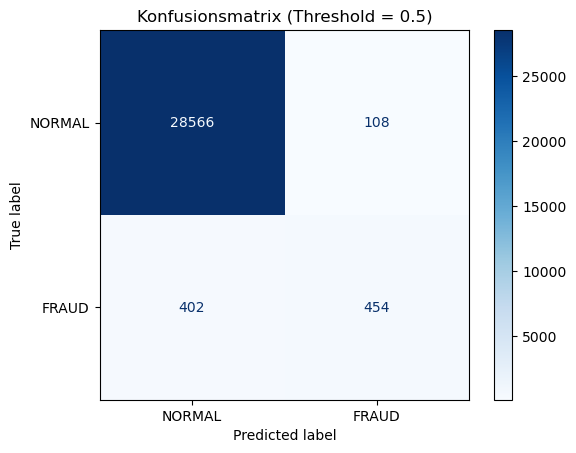

Evaluierung des Modells (Threshold = 0.5):
Accuracy       : 0.9827
Precision      : 0.8078
Recall         : 0.5304
F1-Score       : 0.6403
ROC AUC-Score  : 0.9469


In [15]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

# Schwellenwert definieren (z. B. 0.5 oder optimierter Wert)
threshold = 0.5
y_pred_clf = (y_proba_clf >= threshold).astype(int)

# Konfusionsmatrix anzeigen
cm = confusion_matrix(y_test_clf, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "FRAUD"])
disp.plot(cmap="Blues")
plt.title(f"Konfusionsmatrix (Threshold = {threshold})")
plt.show()

# Klassifikationsmetriken
acc = accuracy_score(y_test_clf, y_pred_clf)
prec = precision_score(y_test_clf, y_pred_clf, zero_division=0)
rec = recall_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf)
roc_auc = roc_auc_score(y_test_clf, y_proba_clf)

print(f"Evaluierung des Modells (Threshold = {threshold}):")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1-Score       : {f1:.4f}")
print(f"ROC AUC-Score  : {roc_auc:.4f}")


# Regression für damage

## Modelltraining: Regression
Ziel:
Vorhersage der Schadenshöhe bei Betrugsfällen (Regression nur auf FRAUD-Fälle trainiert)

Vorgehen:
Zum Training werdenalle FRAUD-Fälle und eine gleiche Anzahl NORMAL-Fälle verwendet.

Eingesetztes Modell: GradientBoostingRegressor, da der "damage" rechtsschief verteilt ist.

Evaluationsmetriken:

R²-Score (~0.46)

MAE, MSE, RMSE

Ziel ist es, den zu erwartenden Schaden möglichst genau abzuschätzen


## Zielvariable vorbereiten

In [16]:
fraud_data = df[df["label"] == "FRAUD"]
no_fraud_data = df[df["label"] == "NORMAL"]
tr_nr = no_fraud_data.transaction_id.unique()
import numpy as np

# Ziehe 4278 zufällige IDs ohne Zurücklegen
np.random.seed(42)
sampled_ids = np.random.choice(tr_nr, size=4278, replace=False)
stpr = no_fraud_data[no_fraud_data.transaction_id.isin(sampled_ids)]


data = pd.concat([fraud_data, stpr])

In [17]:
#Training beschränkt auf FRAUD-Datensätze und der selben Anzahl von no-FRAUD-Datensätzen

X_reg = data.drop(columns=["transaction_id", "damage", "label"])
y_reg = data["damage"]

X_reg = pd.get_dummies(X_reg, columns=["payment_medium"], drop_first=True)
X_reg = pd.get_dummies(X_reg, columns=["feedback_categorical"], drop_first=True)

# Split in Trainings- und Testdaten
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2,  random_state=42
)

In [18]:
reg_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42)


reg_model.fit(X_train_reg, y_train_reg)

GradientBoostingRegressor(max_depth=4, random_state=42)

In [19]:
y_pred_reg = reg_model.predict(X_test_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print("R²-Score:", r2)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print("MAE:", mae)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)


R²-Score: 0.4677434682163415
MAE: 1.928739420938318
MSE: 15.987261053940397
RMSE: 3.9984073146617263


## Entscheidungsstrategie
Logik:
Verwende y_proba_clf (FRAUD-Wahrscheinlichkeit) aus dem Klassifikationsmodell

Verwende y_pred_damage aus dem Regressionsmodell für Schadensschätzung

Berechne für jede Transaktion:
<!--  -->
Erwarteter Gewinn/Kosten bei Kontrolle:
expected_cost_control = p_fraud * gain_tp - (1 - p_fraud) * cost_fp

Erwarteter Schaden bei Nicht-Kontrolle:
expected_cost_no_control = - p_fraud * damage_prediction

Kontrolle wird empfohlen, wenn expected_cost_control > expected_cost_no_control


In [20]:
# geschätzter Schaden für den gesamten Test-Datensatz
y_pred_damage = reg_model.predict(X_test_clf)

In [21]:
# Parameter
gain_tp = 5.0
cost_fp = 10.0

In [22]:

# Erwarteter Gewinn bei Entscheidung
expected_gain_control = y_proba_clf * gain_tp - (1 - y_proba_clf) * cost_fp
expected_gain_no_control = -y_proba_clf * y_pred_damage

# Entscheidung: Kontrollieren, wenn Kontrolle günstiger
decision_full = (expected_gain_control > expected_gain_no_control).astype(int)

# Realisierte Gewinne/Kosten berechnen
actuals = y_test_clf.reset_index(drop=True)
damage_vals = damage_test.reset_index(drop=True)

# Initialisiere Gesamtgewinn
total_gain = 0

# Durchlaufe jeden Fall einzeln
for i in range(len(decision_full)):
    if decision_full[i] == 1:  # Kontrolle
        if actuals[i] == 1:
            total_gain += gain_tp  # Treffer
        else:
            total_gain -= cost_fp  # Fehlalarm
    else:  # Keine Kontrolle
        if actuals[i] == 1:
            total_gain -= damage_vals[i]  # Schaden tritt ein
        else:
            pass  # korrekt ignoriert

print(total_gain)




-1069.1800000000005


## Kostenanalyse mit Schwellenwerten
Du untersuchst in verschiedenen Varianten:

Variante 1: Nur Kontrolle ab einem bestimmten Wahrscheinlichkeitswert p_thresh
→ Ziel: Reduktion der Fehlalarme

Variante 2: Kontrolle nur, wenn Kostenunterschied (margin) eine Schwelle margin_thresh überschreitet
→ Ziel: Nur kontrollieren, wenn Vorteil signifikant --> wird im Folgenden **nicht** berücksichtigt 

Variante 3: Kombination aus beidem – grid search über p_thresh × margin_thresh
Optimierung & Visualisierung

In [23]:
## Variante 1

In [24]:
# Parameter
#gain_tp = 5.0
#cost_fp = 10.0
# Ergebnisse speichern
results = []

thresholds = np.arange(0.1, 1.0, 0.05)

for p_threshold in thresholds:
    # Einschränkung: Nur wenn y_proba_clf >= Schwelle, dann wird überhaupt geprüft
    mask = y_proba_clf >= p_threshold

    # Initial: keine Kontrolle (0)
    decision_thresh  = np.zeros_like(y_proba_clf, dtype=int)

    # Nur dort, wo die Schwelle überschritten wird, wird Entscheidung aktiv getroffen
    decision_thresh [mask] = (expected_gain_control[mask] > expected_gain_no_control[mask]).astype(int)

    # Vektorisiert: Berechnung der tatsächlichen Kosten
    gain_array = np.zeros_like(y_proba_clf)

    # Fälle mit Kontrolle
    tp_mask = (decision_thresh  == 1) & (y_test_clf == 1)
    fp_mask = (decision_thresh  == 1) & (y_test_clf == 0)

    gain_array[tp_mask] += gain_tp
    gain_array[fp_mask] -= cost_fp

    # Fälle ohne Kontrolle
    fn_mask = (decision_thresh == 0) & (y_test_clf == 1)
    gain_array[fn_mask] -= damage_test[fn_mask].values

    total_gain = gain_array.sum()
    total_controls = decision_thresh .sum()


    results.append({
        "p_threshold": round(p_threshold, 2),
        "Kontrollen": int(total_controls),
        "Gesamtkosten": round(total_gain, 2)
    })

# Ausgabe als DataFrame
results_df = pd.DataFrame(results)

print("p_threshold für Parameter gain_tp = 5 und cost_fp:")
print(" ")
print(results_df)


p_threshold für Parameter gain_tp = 5 und cost_fp:
 
    p_threshold  Kontrollen  Gesamtkosten
0          0.10         564      -1069.18
1          0.15         564      -1069.18
2          0.20         564      -1069.18
3          0.25         564      -1069.18
4          0.30         564      -1069.18
5          0.35         564      -1069.18
6          0.40         563      -1059.18
7          0.45         561      -1095.32
8          0.50         547      -1155.03
9          0.55         520      -1174.46
10         0.60         477      -1178.91
11         0.65         454      -1283.79
12         0.70         427      -1320.29
13         0.75         400      -1506.38
14         0.80         384      -1616.12
15         0.85         349      -1888.66
16         0.90         268      -2720.02
17         0.95         128      -4265.20


## Variante 3

In [25]:


# Erwartete Kosten

margin = expected_gain_control - expected_gain_no_control

# Ergebnisse sammeln
results = []

# Grid
p_thresh_grid = np.arange(0.05, 1.00, 0.1)
margin_thresh_grid = np.arange(0, 12, 2)

for p_thresh in p_thresh_grid:
    for margin_thresh in margin_thresh_grid:
        
        # Bedingung für Kontrolle: beide Bedingungen erfüllt
        decision = ((y_proba_clf >= p_thresh) & (margin >= margin_thresh)).astype(int)

        # Evaluation
        actual_label = y_test_clf.values
        actual_damage = damage_test.values

        tp = ((decision == 1) & (actual_label == 1)).sum()
        fp = ((decision == 1) & (actual_label == 0)).sum()
        fn = ((decision == 0) & (actual_label == 1)).sum()
        tn = ((decision == 0) & (actual_label == 0)).sum()

        # Tatsächliche Gesamtkosten berechnen
        total_cost = (
            - gain_tp * tp      # Belohnung für Treffer
            + cost_fp * fp      # Kosten für Fehlalarm
            + actual_damage[(decision == 0) & (actual_label == 1)].sum()  # Nicht erkannter Schaden
        )

        results.append({
            "p_thresh": round(p_thresh, 2),
            "margin_thresh": margin_thresh,
            "Kontrollen": int(decision.sum()),
            "Treffer": int(tp),
            "Fehlalarme": int(fp),
            "Nicht erkannt": int(fn),
            "Gesamtkosten": round(total_cost, 2)
        })

# Als DataFrame anzeigen
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Gesamtkosten")
display(results_df.head(10))  # zeige die besten 10 Kombinationen


,p_thresh,margin_thresh,Kontrollen,Treffer,Fehlalarme,Nicht erkannt,Gesamtkosten
0,0.05,0,564,457,107,399,1069.18
6,0.15,0,564,457,107,399,1069.18
18,0.35,0,564,457,107,399,1069.18
12,0.25,0,564,457,107,399,1069.18
24,0.45,0,561,455,106,401,1095.32
31,0.55,2,491,418,73,438,1132.14
25,0.45,2,493,419,74,437,1135.06
1,0.05,2,494,419,75,437,1145.06
19,0.35,2,494,419,75,437,1145.06
7,0.15,2,494,419,75,437,1145.06


## Heatmap 1:
Y-Achse: margin_thresh

X-Achse: p_thresh

Für jede Kombination werden die Gesamtkosten ermittelt.
### gain_tp = 5 und cost_fp =10

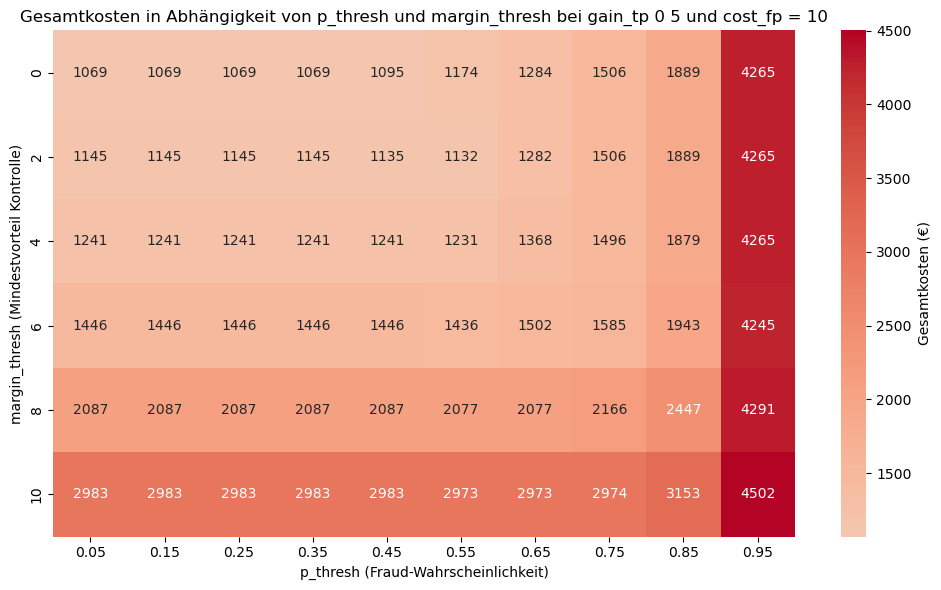

In [26]:


# Pivotieren für Heatmap (x = p_thresh, y = margin_thresh)
heatmap_data = results_df.pivot(
    index="margin_thresh", 
    columns="p_thresh", 
    values="Gesamtkosten"
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="coolwarm",
    center=0,
    cbar_kws={'label': 'Gesamtkosten (€)'}
)

plt.title("Gesamtkosten in Abhängigkeit von p_thresh und margin_thresh bei gain_tp 0 5 und cost_fp = 10")
plt.xlabel("p_thresh (Fraud-Wahrscheinlichkeit)")
plt.ylabel("margin_thresh (Mindestvorteil Kontrolle)")
plt.tight_layout()
plt.show()


### Im folgenden wir der Einfluss angepasster Werte für gain_tp und cost_fp auf die Höhe der Gesamtkosten bzw. die Höhe des Gewinns untersucht

## Heatmap 2:
Y-Achse: Belohnung gain_tp

X-Achse: Kosten cost_fp

Für jede Kombination wird die optimale Schwelle (p_thresh, margin_thresh) gesucht, die maximalen Gewinn liefert

gain_tp: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


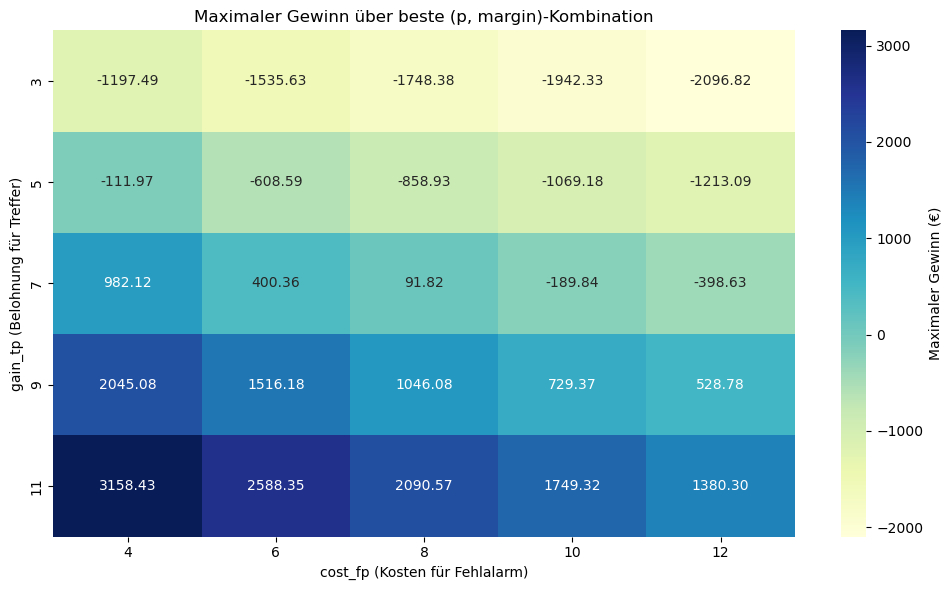

In [27]:

from tqdm import tqdm

# Gitter für Parameterkombinationen
gain_tp_values = np.arange(3, 12, 2)     # z. B. 3, 5, 7, 9, 11
cost_fp_values = np.arange(4, 14, 2)     # z. B. 4, 6, 8, 10, 12

p_thresholds = np.arange(0.05, 1.00, 0.1)      # Schwelle für Klassifikation np.linspace(0.0, 1.0, 21)
margin_thresholds = np.arange(0, 12, 2) # Schwelle für Margen-Vorteil  np.linspace(0.0, 15.0, 31)

# Ergebnis-DataFrame vorbereiten
heatmap_data = pd.DataFrame(index=gain_tp_values, columns=cost_fp_values)

# Fortschrittsanzeige mit tqdm
for gain_tp in tqdm(gain_tp_values, desc="gain_tp"):
    for cost_fp in cost_fp_values:
        max_gain = -np.inf  # Wir suchen jetzt den maximalen Gewinn

        for p_thresh in p_thresholds:
            for margin_thresh in margin_thresholds:
                # Entscheidungsregel
                should_control = (
                    (y_proba_clf >= p_thresh) &
                    ((y_proba_clf * gain_tp - (1 - y_proba_clf) * cost_fp) -
                     (-y_proba_clf * y_pred_damage) >= margin_thresh)
                )

                # Vektorisierte Auswertung
                control = should_control.astype(int)
                tp = (control == 1) & (y_test_clf == 1)
                fp = (control == 1) & (y_test_clf == 0)
                fn = (control == 0) & (y_test_clf == 1)

                total_gain = 0
                total_gain += tp.sum() * gain_tp
                total_gain -= fp.sum() * cost_fp
                total_gain -= damage_test[fn].sum()

                if total_gain > max_gain:
                    max_gain = total_gain  # Jetzt: maximaler Gewinn

        heatmap_data.loc[gain_tp, cost_fp] = max_gain

# Konvertiere in float (für saubere Darstellung)
heatmap_data = heatmap_data.astype(float)

# Visualisierung
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Maximaler Gewinn (€)'})
plt.title("Maximaler Gewinn über beste (p, margin)-Kombination")
plt.xlabel("cost_fp (Kosten für Fehlalarm)")
plt.ylabel("gain_tp (Belohnung für Treffer)")
plt.tight_layout()
plt.show()


In [28]:
import shap

# Daten in float konvertieren (wichtig für SHAP!)
X_train_clf = X_train_clf.astype(float)
X_test_clf = X_test_clf.astype(float)

# Explainer erzeugen (TreeExplainer passt perfekt zu XGBoost)
explainer = shap.TreeExplainer(model)

# SHAP-Werte berechnen
shap_values = explainer.shap_values(X_test_clf)


C:\Users\Matthias Bald\AppData\Local\Temp\ipykernel_5104\3427787829.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_clf)


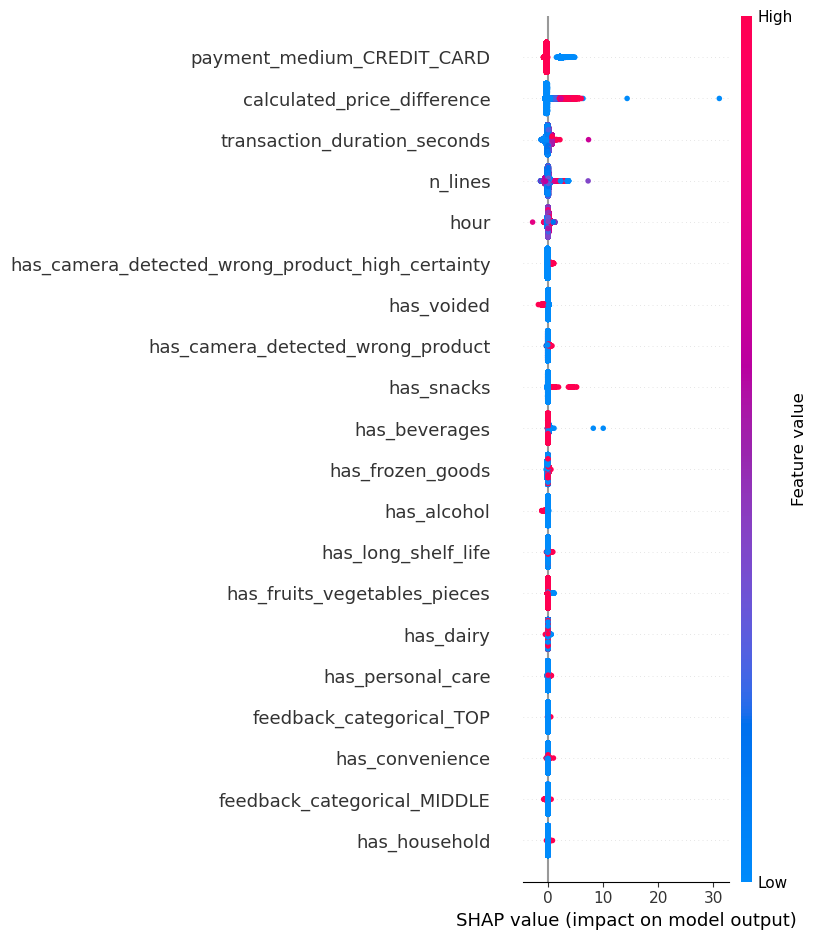

In [29]:
shap.summary_plot(shap_values, X_test_clf)

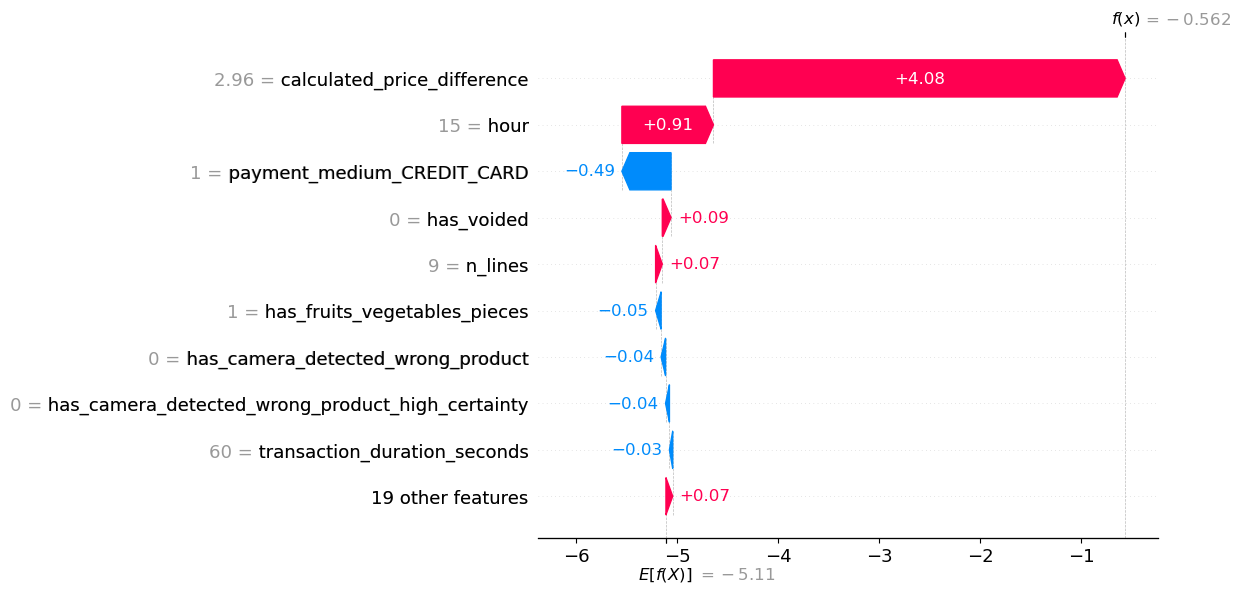

In [30]:
i = 2900  # Beispielindex
model.predict_proba(X_test_clf.iloc[[i]])

shap.plots.waterfall(
    shap.Explanation(values=shap_values[i],
                     base_values=explainer.expected_value,
                     data=X_test_clf.iloc[i],
                     feature_names=X_test_clf.columns.tolist())
)
